In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Major\ Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Major Project


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [ ]:
dataroot = 'GANDatasets/MaleNeutral'
workers = 2
batch_size = 128
image_size = 224
nc = 1
nz = 5
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ])

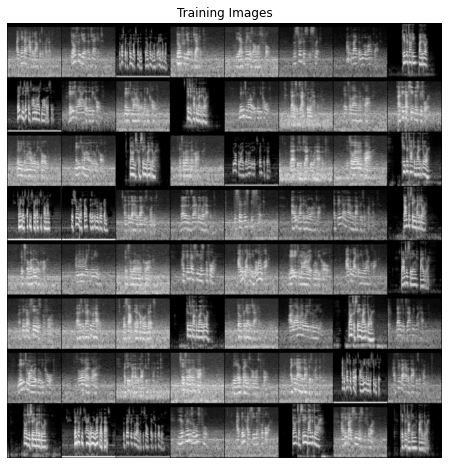

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 6, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d( ngf * 2, ngf, 6, 3, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d( ngf, ngf, 6, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(5, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(3, 3), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.Dropout2d(0.5),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            #
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.Dropout2d(0.5),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.Dropout2d(0.5),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #
            nn.Conv2d(nc, ndf, 6, 3, 2, bias=False,),
            nn.LeakyReLU(0.2, inplace=True),
            #
            nn.Conv2d(ndf, ndf * 4, 6, 3, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.4, inplace=False),
            #
            nn.Conv2d(ndf * 4, ndf * 8, 6, 3, 2, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #
            nn.Conv2d(ndf * 8, 1, 6, 3, 0, bias=False,),            
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)

In [ ]:
Net = Discriminator(ngpu).to(device)
a=Image.open('ImageDatasets/MainDataset/male_surprise/DC_su08.png').convert('RGB')
out = Net(torch.unsqueeze(transform(a),0).to(device))
print(out.size())

torch.Size([1, 1, 1, 1])


In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(6, 6), stride=(3, 3), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 256, kernel_size=(6, 6), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.4, inplace=False)
    (6): Conv2d(256, 512, kernel_size=(6, 6), stride=(3, 3), padding=(2, 2), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 1, kernel_size=(6, 6), stride=(3, 3), bias=False)
    (10): Sigmoid()
  )
)


In [ ]:

criterion = nn.BCELoss()

#Latent vector
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[:64], padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/100][0/7]	Loss_D: 2.2008	Loss_G: 8.5231	D(x): 0.7250	D(G(z)): 0.7035 / 0.0013
[1/100][0/7]	Loss_D: 17.4225	Loss_G: 0.8533	D(x): 0.9479	D(G(z)): 0.9986 / 0.5354
[2/100][0/7]	Loss_D: 16.9141	Loss_G: 1.0546	D(x): 0.9104	D(G(z)): 0.9878 / 0.4971
[3/100][0/7]	Loss_D: 11.2168	Loss_G: 2.4522	D(x): 0.8619	D(G(z)): 0.9975 / 0.1803
[4/100][0/7]	Loss_D: 10.6451	Loss_G: 4.7517	D(x): 0.5787	D(G(z)): 0.9986 / 0.0441
[5/100][0/7]	Loss_D: 6.6765	Loss_G: 7.6784	D(x): 0.6764	D(G(z)): 0.9716 / 0.0022
[6/100][0/7]	Loss_D: 3.0235	Loss_G: 7.5603	D(x): 0.6954	D(G(z)): 0.7369 / 0.0026
[7/100][0/7]	Loss_D: 2.1808	Loss_G: 6.1102	D(x): 0.7909	D(G(z)): 0.6561 / 0.0076
[8/100][0/7]	Loss_D: 4.0274	Loss_G: 2.8869	D(x): 0.3005	D(G(z)): 0.4732 / 0.2313
[9/100][0/7]	Loss_D: 6.8553	Loss_G: 1.7760	D(x): 0.1718	D(G(z)): 0.6299 / 0.5295
[10/100][0/7]	Loss_D: 5.7405	Loss_G: 3.6715	D(x): 0.5728	D(G(z)): 0.8758 / 0.1363
[11/100][0/7]	Loss_D: 5.8115	Loss_G: 1.7308	D(x): 0.1828	D(G(z)): 0.7539 / 0.3

KeyboardInterrupt: ignored

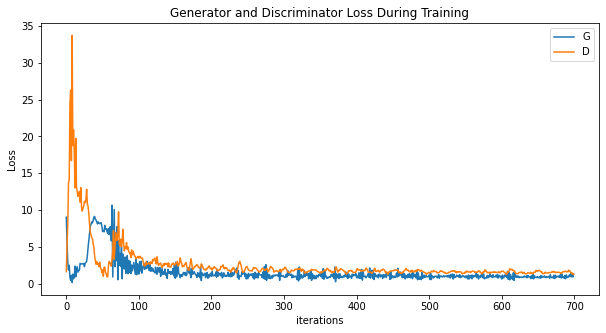

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#torch.save(netG.state_dict(),'GAN/DCGAN_BnW_1.pt')

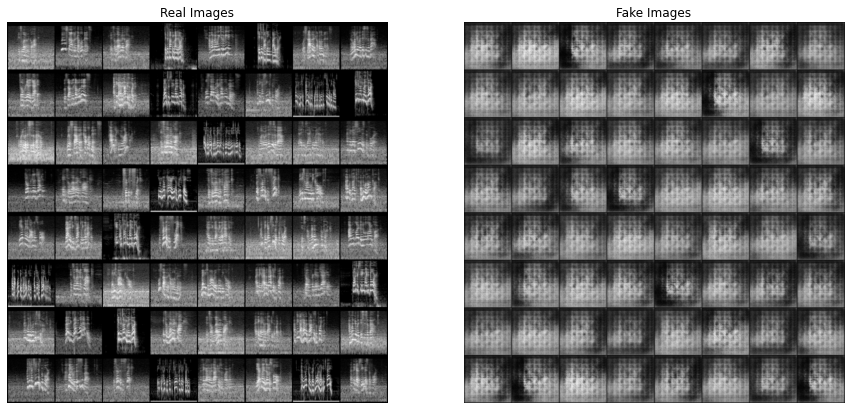

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
#torch.save(netG.state_dict(),'GAN/DCGAN_BnW_MaleFear.pt')
model = Generator(ngpu).to(device)
model.load_state_dict(torch.load('GAN/DCGAN_BnW_FemaleSurprise_1.pt',map_location=torch.device(device)))
model = model.to(device)
model.eval();

In [ ]:
n=250
noise = torch.randn(n, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise).detach().cpu()
for f in range(n):
  save_image(fake[f], f'ImageDatasets/BnWDataset2/male_neutral/fimg{f}.png')

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [ ]:
torch.save(netG.state_dict(),'GAN/DCGAN_BnW_MaleFear.pt')